### Задача: проанализировать совершенные покупки и ответить на следующие вопросы:

[1. Сколько у нас пользователей, которые совершили покупку только один раз?](#first-bullet)

[2. Сколько заказов в месяц в среднем не доставляется по разным причинам(вывести детализацию по причинам)?](#second-bullet)

[3. По каждому товару определить, в какой день недели товар чаще всего покупается.](#third-bullet) 

[4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?](#fourth-bullet)

[5. Написать функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выявить когорту с самым высоким retention на 3-й месяц.](#fifth-bullet)

[6. Построить RFM-кластеры для пользователей. Вывести для каждого кластера средние значения метрик R, F, M (и описать подробно, как были построены метрики R, F, M).](#sixth-bullet)


##### Файлы:  
- [olist_customers_datase.csv](https://disk.yandex.ru/d/FUi5uSd6BfG_ig) — **таблица с уникальными идентификаторами пользователей**  
**customer_id** — позаказный идентификатор пользователя (аналог номера паспорта, ключ между разными таблицами)  
**customer_unique_id** —  уникальный идентификатор пользователя  
**customer_zip_code_prefix** —  почтовый индекс пользователя  
**customer_city** —  город доставки пользователя  
**ustomer_state** —  штат доставки пользователя  
<br>
- [olist_orders_dataset.csv](https://disk.yandex.ru/d/t9Li4JOfgxuUrg) —  **таблица заказов**  
**order_id** —  уникальный идентификатор заказа (номер чека)  
**customer_id** —  позаказный идентификатор пользователя (аналог номера паспорта, ключ между разными таблицами)  
**order_status** —  статус заказа  
**order_purchase_timestamp** —  время создания заказа  
**order_approved_at** —  время подтверждения оплаты заказа  
**order_delivered_carrier_date** —  время передачи заказа в логистическую службу  
**order_delivered_customer_date** —  время доставки заказа  
**order_estimated_delivery_date** —  обещанная дата доставки  
<br>
- [olist_order_items_dataset.csv](https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw) —  **товарные позиции, входящие в заказы**  
**order_id** —  уникальный идентификатор заказа (номер чека)   
**order_item_id** —  идентификатор товара внутри одного заказа  
**product_id** —  ид товара (аналог штрихкода)  
**seller_id** — ид производителя товара  
**shipping_limit_date** —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике  
**price** —  цена за единицу товара  
**freight_value** —  вес товара  

Уникальный статусы заказов в таблице **olist_order_dataset**:  
- **created** —  создан   
- **approved** —  подтверждён  
- **invoiced** —  выставлен счёт  
- **processing** —  в процессе сборки заказа  
- **shipped** —  отгружен со склада  
- **delivered** —  доставлен пользователю  
- **unavailable** —  недоступен  
- **canceled** —  отменён  

In [1]:
import pandas as pd
import numpy as np
from operator import attrgetter
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from scipy.stats import boxcox 
import requests
from urllib.parse import urlencode

In [2]:
# загружаем данные (без скачивания файлов)

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = ['https://disk.yandex.ru/d/FUi5uSd6BfG_ig', 
              'https://disk.yandex.ru/d/t9Li4JOfgxuUrg',
              'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw']                # ссылки на данные

file_names = ['olist_customers_dataset.csv', 
             'olist_orders_dataset.csv',
             'olist_order_items_dataset.csv']                           # имена файлов

datasets = ['customers', 'orders', 'order_items']

for i in range(3):
    # получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key[i]))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    # загружаем данные по ссылкам
    globals()[datasets[i]] = pd.read_csv(download_url)

In [3]:
print('Число строк в customers:  ', customers.shape[0])
print('Число строк в orders:     ', orders.shape[0])
print('Число строк в order_items:', order_items.shape[0])

Число строк в customers:   99441
Число строк в orders:      99441
Число строк в order_items: 112650


In [4]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [6]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [7]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [8]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [9]:
order_items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

Колонки с датами в __*orders*__ и __*order_items*__ - строковые. Переведём их в тип дат.

In [10]:
# список колонок со временем в orders
time_col_ls = ['order_purchase_timestamp', 
          'order_approved_at', 
          'order_delivered_carrier_date', 
          'order_delivered_customer_date', 
          'order_estimated_delivery_date']

In [11]:
# переводим временные колонки orders в тип дат
orders[time_col_ls] = orders[time_col_ls].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))

# переводим временную колонку order_items в тип дат
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'], format='%Y-%m-%d')

In [12]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [13]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [14]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [15]:
order_items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

### Что считать покупкой? 
Первое, что приходит в голову - посмотреть `order_approved_at` (время подтверждения оплаты заказа). Оплатил - значит купил.  
Проверим сколько записей в этой колонке отсутствует.

In [16]:
orders.order_approved_at.isna().sum()

160

Какой статус имеют заказы без подтверждения оплаты?

In [17]:
# отберём только те, где order_approved_at с пропусками и посмотрим на значения order_status
(
    orders[orders.order_approved_at.isna()]
        .order_status
        .value_counts()
)

canceled     141
delivered     14
created        5
Name: order_status, dtype: int64

**'canceled'** - здесь всё понятно, заказы с этим статусом нельзя считать покупками.  
**'created'** - созданные, но, по всей видимости, ещё не оплаченные, а значит они ещё не куплены (и будут ли оплачены неизвестно).  
**'delivered'** - доставленные пользователю, мне понимается это, как факт получения товара покупателем. Если нет даты подтверждения оплаты, возможно, имеет место какой-то сбой в системе.     
Взглянем на детали заказа доставленных, но с пропусками даты оплаты.

Найдём список `order_id` из __*orders*__ со статусом **delivered** и отфильтруем по нему __*order_items*__.

In [18]:
# отфильтруем orders по пропускам в order_approved_at и order_status == "delivered"
delivered_not_approved = (
    orders
        .query('order_approved_at.isna() and order_status == "delivered"')
)
delivered_not_approved

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


In [19]:
# отфильтруем order_items по значениям order_id из предыдущего шага
delivered_not_approved_items = (
    order_items
        .query('order_id in @delivered_not_approved.order_id')
)
delivered_not_approved_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
8204,12a95a3c06dbaec84bcfb0e2da5d228a,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-21 12:05:55,79.99,15.77
19005,2babbb4b15e6d2dfe95e2de765c97bce,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-22 16:15:03,79.99,26.82
20473,2eecb0d85f281280f79fa00f9cec1a95,1,4fd676d9c4723d475026e40aeae56957,5fd924b4836098a5be0ecf81ba054ce0,2017-02-21 16:21:55,135.00,19.23
26393,3c0b8706b065f9919d0505d3b3343881,1,db8ed3d08891d16a2438a67ab3acb740,004c9cd9d87a3c30c522c48c4fc07416,2017-02-22 14:53:27,133.99,23.20
36128,51eb2eebd5d76a24625b31c33dd41449,1,7868a64aa111bbb4f41f8e1146c0becb,cca3071e3e9bb7d12640c9fbe2301306,2017-02-28 14:52:27,59.90,17.16
40822,5cf925b116421afa85ee25e99b4c34fb,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-22 15:48:35,79.99,26.82
49309,7002a78c79c519ac54022d4f8a65e6e8,1,c3b271f47e73d0c9ccf1b43b7606c705,cca3071e3e9bb7d12640c9fbe2301306,2017-01-29 22:26:59,45.90,14.52
49336,7013bcfc1c97fe719a7b5e05e61c12db,1,583916a5dae918f5e89baec139141c54,3481aa57cd91f9f9d3fa1fa12d9a3bf7,2017-02-22 12:29:47,49.99,15.53
59699,88083e8f64d95b932164187484d90212,1,8c5876b1c7768217964f353bc7e64393,0db783cfcd3b73998abc6e10e59a102f,2017-02-22 21:49:19,49.00,14.52
59700,88083e8f64d95b932164187484d90212,2,8c5876b1c7768217964f353bc7e64393,0db783cfcd3b73998abc6e10e59a102f,2017-02-22 21:49:19,49.00,14.52


По всем параметрам это покупки (если не считать возможным подарки, или покупку за бонусы). **Будем считать доставленные заказы без указания даты оплаты покупками.**

In [20]:
# сравним количество строк отфильтрованных датафрэймов
print('Число строк в delivered_not_approved:      ', delivered_not_approved.shape[0])
print('Число строк в delivered_not_approved_items:', delivered_not_approved_items.shape[0])

Число строк в delivered_not_approved:       14
Число строк в delivered_not_approved_items: 15


Выясним, что это за повторы 

In [21]:
# найдём повторы order_id
order_id_duplicated = (
    delivered_not_approved_items
        .loc[
            delivered_not_approved_items
                .duplicated(subset='order_id', keep=False)
        ]
)
order_id_duplicated

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
59699,88083e8f64d95b932164187484d90212,1,8c5876b1c7768217964f353bc7e64393,0db783cfcd3b73998abc6e10e59a102f,2017-02-22 21:49:19,49.0,14.52
59700,88083e8f64d95b932164187484d90212,2,8c5876b1c7768217964f353bc7e64393,0db783cfcd3b73998abc6e10e59a102f,2017-02-22 21:49:19,49.0,14.52


Совпадает всё, кроме `order_item_id` (идентификатор товара внутри одного заказа). Видимо это 2 одинаковых товара в одном заказе.  
Попутно больше узнали о датасете __*olist_order_items_dataset.csv*__ - скорее всего в нём содержатся записи по каждой единице товара разными строками, одинаковые в том числе.

Выясним, есть ли пропуски в `order_status` датафрэйма __*orders*__

In [22]:
(
    orders
        .order_status
        .isna()
        .sum()
)

0

Какой статус имеют заказы c подтверждением оплаты?

In [23]:
# отберём только те, где order_approved_at без пропусков и посмотрим на значения order_status
(
    orders[orders.order_approved_at.isna() == False]
        .order_status
        .value_counts()
)

delivered      96464
shipped         1107
unavailable      609
canceled         484
invoiced         314
processing       301
approved           2
Name: order_status, dtype: int64

Получается все, кроме **'created'**.

**'approved'** — подвтверждён и оплачен — **покупка**;  
**'invoiced'** — выставлен счёт и оплачен — **покупка**;  
**'processing'** — оплачен и собирается — **покупка**;  
**'shipped'** — оплачен и отгружен — **покупка**;  
**'delivered'** — оплачен и доставлен - **покупка**;  
**'unavailable'** — недоступен — скорее всего выполнить заказ не удастся;  
**'canceled'** — отменён — нельзя считать покупкой.  

В итоге, покупкой будем считать все статусы, кроме:
- **'created'** (встречается только в заказах с пропусками оплаты),  
- **'unavailable'** (скорее всего выполнить не удастся),   
- **'canceled'** (отменён).  

Значения в колонке `order_approved_at` учитывать не будем (учтено при выборе допустимых статусов).

In [24]:
# список статусов, которые не будем считать покупками
no_purchases_statuses = ['created', 'unavailable', 'canceled']

### 1. Сколько у нас пользователей, которые совершили покупку только один раз? <a class="anchor" id="first-bullet"></a>

Теперь взглянем на датафрэйм __*customers*__. Хочется понять связь между `customer_id` (позаказный идентификатор пользователя) и `customer_unique_id` (уникальный идентификатор пользователя), чтобы решить по какой колонке смотреть покупки пользователей.   
Сравним количество уникальных `customer_id` и `order_id` в __*customers*__ и __*orders*__:

In [25]:
print('orders: количество уникальных значений customer_id:   ', orders.customer_id.nunique())
print('orders: количество уникальных значений order_id:      ', orders.order_id.nunique())
print('orders: общее количество строк:                       ', orders.shape[0])
print('customers: количество уникальных значений customer_id:', customers.customer_id.nunique())
print('customers: общее количество строк:                    ', customers.shape[0])
print('customers: количество уникальных customer_unique_id:  ', customers.customer_unique_id.nunique())
print('customers: количество пропусков  customer_unique_id:  ', customers.customer_unique_id.isna().sum())

orders: количество уникальных значений customer_id:    99441
orders: количество уникальных значений order_id:       99441
orders: общее количество строк:                        99441
customers: количество уникальных значений customer_id: 99441
customers: общее количество строк:                     99441
customers: количество уникальных customer_unique_id:   96096
customers: количество пропусков  customer_unique_id:   0


Все `customer_id` в  __*customers*__ и __*orders*__ уникальны, и им соответствуют уникальные `order_id`.  По `customer_id` можно объединить эти датафрэймы. Если количество строк inner join при этом сохранится, значит значения `customer_id` в этих датафрэймах полностью совпадают.  

Похоже на то, что на часть `customer_unique_id` приходится по несколько `customer_id`. Убедимся в этом визуально, показав дубликаты `customer_unique_id`. 

In [26]:
(
    customers
        .loc[customers
                .duplicated(keep=False, subset='customer_unique_id')]
        .sort_values('customer_unique_id')
        .head()
)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
35608,24b0e2bd287e47d54d193e7bbb51103f,00172711b30d52eea8b313a7f2cced02,45200,jequie,BA
19299,1afe8a9c67eec3516c09a8bdcc539090,00172711b30d52eea8b313a7f2cced02,45200,jequie,BA
20023,1b4a75b3478138e99902678254b260f4,004288347e5e88a27ded2bb23747066c,26220,nova iguacu,RJ
22066,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,26220,nova iguacu,RJ
72451,49cf243e0d353cd418ca77868e24a670,004b45ec5c64187465168251cd1c9c2f,57055,maceio,AL


Следовательно при оценке покупок необходимо ориетнироваться на `customer_unique_id`. Для этого объединим датасеты __*customers*__  и __*orders*__ по колонке `customer_id`.

In [27]:
customers_orders_merged = customers.merge(orders, on='customer_id')
customers_orders_merged.shape

(99441, 12)

Количество строк у объединённого датафрэйма осталось таким же - значит все значения `customer_id` в обоих датафрэймах полностью совпадают и никакие значения при объединении не потеряны.

In [28]:
customers_orders_merged.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


### Число пользователей, совершивших покупку только один раз:

In [29]:
(
    customers_orders_merged
        .query('order_status not in @no_purchases_statuses')  # убираем строки со статусами-непокупками
        .groupby('customer_unique_id', as_index=False)        # группируем по customer_unique_id
        .agg({'customer_id': 'count'})                        # подсчитываем количество покупок на каждого уник. пользователя
        .query('customer_id == 1')                            # отбираем тех, у кого количество покупок = 1
        .shape[0]
)

92099

### Какой заказ считать недоставленным?

Здесь напрашиваются два варианта:
1. Всё, что имеет статус отличный от **delivered**;
2. Отсутствует дата доставки.  

Проверим как согласуются колонки со статусом и временем доставки.

In [30]:
# уникальные значения статуса среди непропущенных 
# значений order_delivered_customer_date в orders
(
    orders
        .query('order_delivered_customer_date.isna() == False')
        .order_status
        .value_counts()
)

delivered    96470
canceled         6
Name: order_status, dtype: int64

Выходит, что 6 заказов, имеющих дату доставки имеют статус "отменён"

In [31]:
# отменённые заказы с датой доставки клиенту
(
    orders
        .query('order_delivered_customer_date.isna() == False and order_status == "canceled"')
)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


А отменены они, потому что время доставки превысило обещанное.

In [32]:
# значения order_status при пропущенных датах доставки в orders
(
    orders
        .query('order_delivered_customer_date.isna() == True')
        .order_status
        .value_counts()
)

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: order_status, dtype: int64

Отсюда видно, что 8 заказов со статусом "доставлено" не имеют дат доставки клиенту. Посмотрим на них.

In [33]:
# orders с пропущенными датами достаки, при этом имеющие статус "доставлен"
(
    orders
        .query('order_delivered_customer_date.isna() == True and order_status == "delivered"')
)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


Здесь не наблюдается каких-то закономерностей, в силу неизвестных нам причин заказы одновременно имеют статус **delivered** и пропущенные значения `order_delivered_customer_date`.  
Остановимся на версии №1: **всё, что имеет статус отличный от delivered будем считать недоставленным**.

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам? <a class="anchor" id="second-bullet"></a>

In [34]:
# датафрэйм с не доставленными заказами
not_delivered_orders = (
    orders
        .copy()
        .query('order_status != "delivered"')
)

In [35]:
# статусы недоставленных и их количество
(
    not_delivered_orders
        .order_status
        .value_counts()
)

shipped        1107
canceled        625
unavailable     609
invoiced        314
processing      301
created           5
approved          2
Name: order_status, dtype: int64

In [36]:
# добавим колонку содержащую только год и месяц на основе order_estimated_delivery_date
not_delivered_orders['year_month_estimated'] = (
    not_delivered_orders
        .order_estimated_delivery_date
        .dt
        .strftime("%Y-%m")
)

Количество недоставленных заказов по месяцам

In [37]:
# сгруппируем по колонке "year_month_estimated" и статусу заказа, чтобы посчитать количество недоставленных
undelivered_by_month = (
    not_delivered_orders
        .groupby(['year_month_estimated', 'order_status'], as_index=False)
        .agg({'order_id': 'count'})
        .rename(columns={'order_id': 'undelivered'})
)
undelivered_by_month.head()

,year_month_estimated,order_status,undelivered
0,2016-09,canceled,1
1,2016-10,canceled,3
2,2016-10,shipped,1
3,2016-11,canceled,14
4,2016-11,invoiced,9


In [38]:
# среднее количество недоставленных заказов в месяц
undelivered_by_month.undelivered.mean()

25.765217391304347

Посчитаем среднее количество недоставленных заказов в месяц по каждму статусу

In [39]:
# среднее количество недоставленных заказов по месяцам
mean_by_month_df = pd.DataFrame()

for status in undelivered_by_month \
                                .order_status \
                                .unique():
    temp_df = pd.DataFrame(                                                          
        [[status, 
          undelivered_by_month
                  .query('order_status == @status')
                  .undelivered
                  .mean()]], 
                columns=['order_status', 'mean_by_month']
                          )
    mean_by_month_df = pd.concat([mean_by_month_df, temp_df])

mean_by_month_df.sort_values('mean_by_month', inplace=True, ascending=False)
mean_by_month_df = mean_by_month_df.reset_index(drop=True)

### Среднее количество недоставленных заказов в месяц по каждому статусу:

In [40]:
mean_by_month_df

,order_status,mean_by_month
0,shipped,48.130435
1,unavailable,29.000000
2,canceled,24.038462
3,processing,15.842105
4,invoiced,14.952381
5,created,1.666667
6,approved,1.000000


Лидирует в списке статус **shipped**. Сравним для них дату передачи в логистическую службу с обещаной датой доставки.

In [41]:
# недоставленные со статусом shipped
shipped = (
    not_delivered_orders
        .copy()
        .query('order_status == "shipped"')
)

In [42]:
# разница во времени обещаной датой доставки и датой передачи в логистическую службу
shipped['delta_time'] = (
    shipped
        .order_estimated_delivery_date
            .sub(shipped
                 .order_delivered_carrier_date)
)

In [43]:
# недоставленные shipped с отрицательной разницей во времени
shipped.query('delta_time < @pd.to_timedelta(0)')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month_estimated,delta_time
6997,1b76802b72eb5517c97481ee2f7b7037,85ac32af92e4e38adeaeb0653a085dfd,shipped,2017-02-08 08:48:43,2017-02-08 08:55:11,2017-03-14 11:00:52,NaT,2017-03-10,2017-03,-5 days +12:59:08
8813,cb503219f1a73d8a4dfe8561be373c99,921822ed81e9c094d7908db16164a270,shipped,2017-11-25 11:22:09,2017-11-25 11:35:20,2018-01-04 21:41:39,NaT,2017-12-21,2017-12,-15 days +02:18:21
19637,c108072ab31ec90a754129c171577f5f,a979b3cbd898fd8be91a290a667fd0d4,shipped,2017-10-16 21:13:03,2017-10-16 21:28:13,2017-10-26 20:40:20,NaT,2017-10-26,2017-10,-1 days +03:19:40
22143,38541d08d4eb7d571b5b80cb6ca9be03,937682b4176cf634c443714be31b5ca7,shipped,2017-11-24 21:36:30,2017-11-25 01:31:42,2018-01-04 21:07:51,NaT,2017-12-20,2017-12,-16 days +02:52:09
40266,19802314932831a78e4f0e3dead30f83,cc825baf36814fe3b4354455ef9a2335,shipped,2017-11-20 11:46:03,2017-11-20 12:10:25,2017-12-14 21:35:17,NaT,2017-12-13,2017-12,-2 days +02:24:43
55472,dd0e00343af091774fc1399707418777,fa4cd2e67f0e9eb36f86d4b1413b059d,shipped,2017-03-06 19:54:12,2017-03-07 04:25:28,2017-04-03 14:32:54,NaT,2017-03-29,2017-03,-6 days +09:27:06
66818,18c89078cd21364b7ad7f4d652e0cb84,2d86160611127e9ccc6c5e70ea08f065,shipped,2017-10-17 17:16:34,2017-10-17 17:46:06,2017-11-01 22:07:45,NaT,2017-10-27,2017-10,-6 days +01:52:15
78402,28bc8f33c194dd4f636717ef490d0921,64ebc89fe827e44bf4c57f7e22676e12,shipped,2018-02-26 12:08:26,2018-02-27 10:48:37,2018-03-17 00:11:31,NaT,2018-03-12,2018-03,-6 days +23:48:29


Как видим, среди **shipped** есть заказы, которые были переданы в логистическую службу уже после срока, отведённого на доставку. Но таких меньшенство.

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается. <a class="anchor" id="third-bullet"></a>

Подробнее взглянем на __*order_items*__

#### Сравнение датафрэймов orders и order_items

Посмотрим на количество уникальных `order_id` в __*orders*__ и __*order_items*__:

In [44]:
print('orders: количество уникальных значений order_id:       ', orders.order_id.nunique())
print('orders: общее количество строк:                        ', orders.shape[0])
print('order_items: количество уникальных значений order_id:  ', order_items.order_id.nunique())
print('order_items: общее количество строк:                  ', order_items.shape[0])

orders: количество уникальных значений order_id:        99441
orders: общее количество строк:                         99441
order_items: количество уникальных значений order_id:   98666
order_items: общее количество строк:                   112650


Общее количество строк __*order_items*__ больше, чем в __*orders*__ (как мы уже выяснили, на каждый `order_id` может приходиться несколько записей товаров), а уникальных значений `order_id` - меньше.  
Взлянем на `order_id`, отсутствующие в __*order_items*__, но присутствующие в __*orders*__:

In [45]:
# список order_id, которых нет в order_items
droped_order_id_ls = orders.query('order_id not in @order_items.order_id.unique()').order_id

# строки с order_id по которым нет данных в order_items
droped_order_id = orders.query('order_id in @droped_order_id_ls')

In [46]:
# количество пропущеных order_id
droped_order_id.shape[0]

775

In [47]:
droped_order_id.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12


Попытаемся найти закономерности

In [48]:
# уникальные значения order_status в строках с пропущенными order_id и их количество
droped_order_id.order_status.value_counts()

unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
Name: order_status, dtype: int64

In [49]:
# общее количетсво строк с order_status == "unavailable" в orders
orders.query('order_status == "unavailable"').shape[0]

609

In [50]:
# общее количетсво строк с order_status == "canceled" в orders
orders.query('order_status == "canceled"').shape[0]

625

In [51]:
# строки droped_order_id с order_status "created", "invoiced" или "shipped"
(
    droped_order_id
        .query('order_status in ["created", "invoiced", "shipped"]')
)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
7434,b5359909123fa03c50bdb0cfed07f098,438449d4af8980d107bf04571413a8e7,created,2017-12-05 01:07:52,NaT,NaT,NaT,2018-01-11
9238,dba5062fbda3af4fb6c33b1e040ca38f,964a6df3d9bdf60fe3e7b8bb69ed893a,created,2018-02-09 17:21:04,NaT,NaT,NaT,2018-03-07
21441,7a4df5d8cff4090e541401a20a22bb80,725e9c75605414b21fd8c8d5a1c2f1d6,created,2017-11-25 11:10:33,NaT,NaT,NaT,2017-12-12
23254,a68ce1686d536ca72bd2dadc4b8671e5,d7bed5fac093a4136216072abaf599d5,shipped,2016-10-05 01:47:40,2016-10-07 03:11:22,2016-11-07 16:37:37,NaT,2016-12-01
55086,35de4050331c6c644cddc86f4f2d0d64,4ee64f4bfc542546f422da0aeb462853,created,2017-12-05 01:07:58,NaT,NaT,NaT,2018-01-08
57591,2ce9683175cdab7d1c95bcbb3e36f478,b2d7ae0415dbbca535b5f7b38056dd1f,invoiced,2016-10-05 21:03:33,2016-10-06 07:46:39,NaT,NaT,2016-11-25
58958,90ab3e7d52544ec7bc3363c82689965f,7d61b9f4f216052ba664f22e9c504ef1,created,2017-11-06 13:12:34,NaT,NaT,NaT,2017-12-01
69926,e04f1da1f48bf2bbffcf57b9824f76e1,0d00d77134cae4c58695086ad8d85100,invoiced,2016-10-05 13:22:20,2016-10-06 15:51:38,NaT,NaT,2016-11-29


In [52]:
# пропуски в колонках со временем droped_order_id
droped_order_id[time_col_ls].isna().sum()

order_purchase_timestamp           0
order_approved_at                146
order_delivered_carrier_date     774
order_delivered_customer_date    775
order_estimated_delivery_date      0
dtype: int64

Все значения `order_delivered_customer_date` (время доставки заказа) пропущены и во всех значениях `order_status` нет:
- **delivered** (доставлен пользователю), 
- **approved** (подтверждён), 
- **processing** (в процессе сборки заказа)  

Большинство из них либо **unavailable**, либо **canceled**.

In [53]:
# всего пропущено order_delivered_customer_date в orders
orders.order_delivered_customer_date.isna().sum()

2965

In [54]:
# всего пропусков order_estimated_delivery_date в orders
orders.order_estimated_delivery_date.isna().sum()

0

In [55]:
# всего пропусков order_purchase_timestamp в orders
orders.order_purchase_timestamp.isna().sum()

0

In [56]:
print('Самая ранняя дата order_estimated_delivery_date в orders:          ', orders.order_estimated_delivery_date.min())
print('Самая ранняя дата order_estimated_delivery_date в droped_order_id: ', droped_order_id.order_estimated_delivery_date.min())
print('Самая поздняя дата order_estimated_delivery_date в orders:         ',orders.order_estimated_delivery_date.max())
print('Самая поздняя дата order_estimated_delivery_date в droped_order_id:', droped_order_id.order_estimated_delivery_date.max())

Самая ранняя дата order_estimated_delivery_date в orders:           2016-09-30 00:00:00
Самая ранняя дата order_estimated_delivery_date в droped_order_id:  2016-09-30 00:00:00
Самая поздняя дата order_estimated_delivery_date в orders:          2018-11-12 00:00:00
Самая поздняя дата order_estimated_delivery_date в droped_order_id: 2018-11-12 00:00:00


Выясним, имеются ли некупленные товары в **order_items**

In [57]:
# order_id некупленных товаров
no_purchases_order_id = (
    orders
        .query('order_status == @no_purchases_statuses')
    .order_id
)

# количетсво строк с заказами в order_items, которые мы не считаем покупками
(
    order_items
        .query('order_id in @no_purchases_order_id')
        .shape[0]
)

549

**Итак, всё, что можно сказать о отсутствующих строках в __*order_items*__ - это часть недоставленных товаров, большая из которых - недоступна или отменена. Почти все недоступные не попали в __*order_items*__.**.  
Также в в __*order_items*__ имеются заказы, которые мы не считаем покупками.

Объединим все датафрэймы в один

In [58]:
total_df = customers_orders_merged.merge(order_items, on='order_id')

In [59]:
total_df.shape

(112650, 18)

In [60]:
order_items.shape

(112650, 7)

In [61]:
total_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


Отберём те строки, что считаются покупками

In [62]:
purchase_total_df = (
    total_df
        .copy()
        .query('order_status not in @no_purchases_statuses')
)
purchase_total_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [63]:
# количество строк с пропущенными датами оплаты в purchase_total_df
purchase_total_df.order_approved_at.isna().sum()

15

Что здесь считать днём покупки? На одном из предыдущих шагах было важно понять была ли оплата, это был ключевой момент для определения совершена ли покупка. Здесь же, на мой взгляд, больше подходит дата создания заказа - это момент, когда человек принимает решение купить, оплата - технический момент, который, безусловно, тоже важен, но больше как сам факт.

Дообавим колонки дней недели на основе `order_purchase_timestamp`.

In [64]:
# добавляем колонку с днями недели создания заказа
purchase_total_df['order_weekday'] = (
    purchase_total_df
        .copy()
        .order_purchase_timestamp
        .dt
        .day_name()
)

In [65]:
purchase_total_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_weekday
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,Tuesday
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,Friday
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,Saturday
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,Tuesday
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,Sunday


За одну покупку определённого товара будем считать его наличие в заказе не зависимо от количества. Т.е. если в заказе, например, 5 одинаковых товаров - это одна покупка, а не 5.

Одинаково часто встречающихся дней недели может быть несколько, чтобы это учесть создадим функцию, отбирающую все дни недели, которые встречаются максимально часто и преобразует их в строку.

In [66]:
# функция собирающая максимально часто встречающиеся дни недели в одну строку
def get_weekdays(weekdays):
    max_vals = weekdays.value_counts().max()
    weekday_list = (weekdays 
            .value_counts()[weekdays.value_counts() == max_vals] 
            .index 
            .tolist())
    return ', '.join(weekday_list)

### Дни недели, в которые чаще всего покупаются товары.

In [67]:
%%time
purchase_weekday_by_product = (
    purchase_total_df
        .groupby(['order_id', 'product_id'], as_index=False)  # сначала избавимся от повторов product_id в заказе: группируем по двум колонкам
        .agg({'order_weekday': 'first'})                      # выбираем первое значение, т.к. они все одинаковые
        .groupby('product_id', as_index=False)                # затем снова группируем, чтобы схлопнуть в одно значение (оставить уникальные)
        .agg({'order_weekday': lambda x: get_weekdays(x)})    # подсчитываем и выбираем значение с максимальным "счётом"
)

CPU times: user 1min 3s, sys: 148 ms, total: 1min 3s
Wall time: 1min 3s


In [68]:
purchase_weekday_by_product.head()

,product_id,order_weekday
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,"Wednesday, Friday"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday


### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?  <a class="anchor" id="fourth-bullet"></a>

Внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [69]:
# добавляем колонку создания заказа в формате "год-месяц"
purchase_total_df['year_month_order'] = (
    purchase_total_df
        .order_purchase_timestamp
        .dt
        .to_period('M')
)

In [70]:
purchase_total_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_weekday,year_month_order
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,Tuesday,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,Friday,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,Saturday,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,Tuesday,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,Sunday,2018-07


Расчитаем и добавим колонку `mean_orders_per_week` со значениями средним значением покупок в неделю  по месяцам для каждого пользователя.

In [71]:
mean_per_week_df = (
    purchase_total_df
        .groupby(['year_month_order', 'customer_unique_id'], as_index=False)             # группируем по году-месяцу и пользователю
        .agg({'order_purchase_timestamp': 'count'})                                      # считаем количество (в месяц на пользователя)
        .assign(weeks_in_month = lambda x: x.year_month_order.dt.daysinmonth / 7)        # добавляем колонку количество недель в текущем месяце
        .rename(columns={'order_purchase_timestamp': 'orders_per_month'})                # переименовываем колонку с подсчётом
        .assign(mean_orders_per_week = lambda x: x.orders_per_month / x.weeks_in_month)  # добавляем колонку в которой делим количество заказов в месяц на количество недель в месяце
        [['year_month_order', 'customer_unique_id', 'mean_orders_per_week']]             # отберём нужные колонки
)

### Итак, количество покупок каждого пользоватлея в неделю по месяцам

In [72]:
mean_per_week_df.head()

,year_month_order,customer_unique_id,mean_orders_per_week
0,2016-09,830d5b7aaa3b6f1e9ad63703bec97d23,0.700000
1,2016-09,b7d76e111c89f7ebf14761390f0f7d17,0.466667
2,2016-10,0032c76b20340da25249092a268ce66c,0.225806
3,2016-10,01f156677184504063bd19739f924af1,0.225806
4,2016-10,0313291a6f4f16df04dcf819d88c38ef,0.225806


### 5. Написать функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выявить когорту с самым высоким retention на 3-й месяц. <a class="anchor" id="fifth-bullet"></a>

In [73]:
# количество уникальных пользователей
num_customers = (
    purchase_total_df
        .groupby(['customer_unique_id'])
        .order_id
        .nunique()
)
# доля пользователей сделавших более 1 заказа
mult_orders_perc = (
    np.sum(num_customers > 1) / purchase_total_df
        .order_id.nunique()
)
print(f'{100 * mult_orders_perc:.2f}% пользователей сделали более одного заказа.')

2.94% пользователей сделали более одного заказа.


In [74]:
# функция для когортного анализа
def user_retention(data, customer_id, date, period='M'):
    '''
    Функция строит retention-матрицу когортного анализа (возвращает датафрэйм)
    Требуются библиотеки: 
        from operator import attrgetter
        import pandas as pd
    Описание полей:
    data        - датафрэйм
    customer_id - колонка с id клиентов (str)
    order_date  - колонка с датами (datetime)
    period      - период разбивки (str, по умолчанию "M" - месяц). Все псевдонимы: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
    '''
    data = data.copy()
    data[date] = data[date].dt.to_period('M')      # переводим колонку дат в тип "период"
    
    # создаём когорты
    users_cohorts = (
        data
            .groupby(customer_id, as_index=False)  # группируем по пользователям
            [date]                                 # выбираем колонку с датами
            .min()                                 # отбираем минимальные колонки для каждого пользователя
            .rename(columns={date: 'cohort'})      # переименовываем колонку с дамами в когорты
    )
    
    # объединим датасеты
    cohorts_df = (
        users_cohorts                                           # датасет с когортами
            .merge(data[[customer_id, date]], on=customer_id)   # объединяем с основным датасетом по пользователям
            .sort_values('cohort')                              # сортируем по когортам
            .rename(columns={date: 'target_action_dates'})      # переименовываем колонку с датами целевых действий
    )
    
    # сгруппируем по когортам и месяцам покупок и посчитаем количество покупателей на каждый месяц
    cohorts_df = (
        cohorts_df
            .groupby(['cohort', 'target_action_dates'], as_index=False)
            .agg(customer_quantity = (customer_id, 'nunique'))
    )
    
    # считаем разницу между первой и последующими покупками, добавляем в столбец
    cohorts_df['period_number'] = (
        cohorts_df
            .target_action_dates                  
            .sub(cohorts_df.cohort)               # вычитаем когорты из времени целевых действий
            .apply(attrgetter('n'))               # передаём атрибут номинальной единицы (т.е. будут те же что и в  period=)
    )
    
    # строим сводную таблицу
    cohort_pivot = cohorts_df.pivot_table(index='cohort', columns='period_number', values='customer_quantity')
    
    # размер когорты = количество пользователей в нулевой период
    cohort_size = cohort_pivot.iloc[:,0]
    
    # строим retention матрицу
    retention_matrix = cohort_pivot.div(cohort_size, axis = 0)

    return retention_matrix


In [75]:
# создаём retention матрицу используя функцию
retention_matrix = user_retention(purchase_total_df, 'customer_unique_id', 'order_purchase_timestamp')

In [76]:
# применим форматирование отображения датафрэйма
ur_style = (retention_matrix
            .style 
            .set_caption('Customer retention by cohort')  # добавляем подпись 
            .background_gradient(cmap='viridis')          # раскрашиваем ячейки по столбцам 
            .highlight_null('white')                      # делаем белый фон для значений NaN 
            .format("{:.2%}", na_rep=""))                 # числа форматируем как проценты, NaN заменяем на пустоту 
ur_style

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,,,,,,,,
2016-10,100.00%,,,,,,0.35%,,,0.35%,,0.35%,,0.35%,,0.35%,,0.35%,0.70%,0.70%
2016-12,100.00%,100.00%,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.40%,0.27%,0.13%,0.40%,0.13%,0.40%,0.13%,0.13%,,0.40%,0.13%,0.66%,0.40%,0.13%,0.13%,0.27%,0.40%,0.13%,
2017-02,100.00%,0.24%,0.30%,0.12%,0.41%,0.12%,0.24%,0.18%,0.12%,0.18%,0.12%,0.30%,0.12%,0.18%,0.12%,0.06%,0.06%,0.24%,,
2017-03,100.00%,0.51%,0.35%,0.39%,0.35%,0.16%,0.16%,0.31%,0.35%,0.08%,0.39%,0.12%,0.23%,0.12%,0.16%,0.23%,0.08%,0.16%,,
2017-04,100.00%,0.60%,0.22%,0.17%,0.30%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.13%,,,
2017-05,100.00%,0.48%,0.48%,0.40%,0.31%,0.34%,0.42%,0.14%,0.25%,0.25%,0.25%,0.34%,0.25%,0.03%,0.20%,0.23%,,,,
2017-06,100.00%,0.45%,0.35%,0.39%,0.26%,0.39%,0.35%,0.23%,0.13%,0.23%,0.32%,0.32%,0.16%,0.13%,0.19%,,,,,


In [77]:
# когорта с максимальным retention на третий месяц 
# в период с января по декабрь 2017 г.
print(retention_matrix.loc['2017-01':'2017-12', 3].idxmax())

2017-05


### 6. Построить RFM-кластеры для пользователей. Вывести для каждого кластера средние значения метрик R, F, M . <a class="anchor" id="sixth-bullet"></a>

R - recency — давность (как давно ваши клиенты что-то покупали);  
F - frequency — частота (как часто клиенты покупают);  
M - monetary — деньги (общая сумма покупок).  

По каждому из этих признаков мы выделяем по нексолько групп (точное количество определим в процессе). Затем присваиваем каждой группе числовое обозначение от 1 до n, где n - число кластеров

За отчётный период берём один год.  

Нам потребуются следующие данные:
- id клиента
- даты покупок
- общее число заказов в течение указанного отчетного периода
- средний чек

Взлянем на даты.

In [78]:
# сегодняшняя дата (действительная)
real_today = (
    pd.to_datetime(
        datetime.datetime.today()
              )
)
real_today

Timestamp('2022-04-08 07:14:08.944717')

In [79]:
# дата первого заказа
first_order_date = (
    purchase_total_df
                 .order_purchase_timestamp
                 .min()
)

In [80]:
# дата последнего заказа
last_order_date = (
    purchase_total_df
                 .order_purchase_timestamp
                 .max()
)

In [81]:
# разница между сегодняшним днём и датой последнего заказа в месяцах
(real_today.to_period('M') - last_order_date.to_period('M')).n

43

In [82]:
# разница между сегодняшним днём и датой первого заказа в месяцах
(real_today.to_period('M') - first_order_date.to_period('M')).n

67

In [83]:
# разница между датами последнего и первого заказов в месяцах
(last_order_date.to_period('M') - first_order_date.to_period('M')).n

24

Последняя дата заказа - сентябрь 2018 и новее данных нет. Разница между сегодняшней датои и датой последнего заказа почти в два раза больше разницы между первым и последним заказом. Получаестся, что дата первого заказа не сильно отличается от даты последнего заказа по отношению к сегодняшнему дню. С этим связана некоторая сложность в оценке того, что принять за "давнюю дату", а что за "недавнюю".  
Чтобы увидеть более реальную картину относительно давности заказов, будем оценивать даты относительно последнего дня заказа, вместо действительного сегодняшнего дня. Т.е. как бы переместимся в прошлое, чтобы посмотреть как вели себя покупатели тогда.  

In [84]:
# условня "сегодняшняя" дата
conditional_today_date = purchase_total_df.order_purchase_timestamp.max()
conditional_today_date

Timestamp('2018-09-03 09:06:57')

In [85]:
# дата начала периода
start_date = conditional_today_date - pd.Timedelta(365, unit='day')
start_date

Timestamp('2017-09-03 09:06:57')

Подготовим датасет для rfm-анализа. Для этого сгруппируем имеющийся датасет с данными о покупках __*purchase_total_df*__ и найдём последнюю дату покупок, средний чек и количество заказов на пользователя.  
На общую сумму полученную с покупателя может влиять количество покупок и, как следствие, дублирование метрик. Поэтому в качестве параметра Monetary выбрана средняя сумма чека.  

In [86]:
# датафрэём для анализа за весь период времени
pre_rfm_all_years = (
    purchase_total_df
        .copy()

    # сначала сгруппируем по заказам
        .groupby('order_id', as_index=False)                     
        .agg({
            'price': 'sum',                               # найдём сумму заказа
            'customer_unique_id': 'first',                # сохраним колонку пользователя, взяв первый элемент из группы
            'order_purchase_timestamp': 'max'             # оставим последнюю дату
        })
    
    # теперь группируем по пользователям
        .groupby('customer_unique_id', as_index=False)           
        .agg({
            'price': 'mean',                              # средний чек
            'order_id': 'count',                          # количество покупок
            'order_purchase_timestamp': 'max'})           # последнее время заказа
        .rename(columns={
            'price': 'avg_bill', 
            'customer_unique_id': 'customer',
            'order_id': 'purchases_quantity',
            'order_purchase_timestamp': 'last_order'
        })
        .assign(day_quantity = lambda x:                  # добавляем колонку с разницей между условным сегодняшним днём и последней покупкой в днях
                (
                    conditional_today_date.to_period('D') - x.last_order.dt.to_period('D')
                )
                .apply(attrgetter('n'))                   # передадим созданной колонке атрибут n, чтобы задать номинальные единицы изменения (дни)
               )
)

Так как отчётный период один год, подготовим вариант датафрэйма с такими же группировками, отфильтровав исходный __*purchase_total_df*__ соответствующим образом.

In [87]:
# датафрэём для анализа за один год
pre_rfm = (
    purchase_total_df
        .copy()
        .query('order_purchase_timestamp >= @start_date') 
    
    # сначала сгруппируем по заказам
        .groupby('order_id', as_index=False)                     
        .agg({
            'price': 'sum',                               # найдём сумму заказа
            'customer_unique_id': 'first',                # сохраним колонку пользователя, взяв первый элемент из группы
            'order_purchase_timestamp': 'max'             # оставим последнюю дату
        })
    
    # теперь группируем по пользователям
        .groupby('customer_unique_id', as_index=False)           
        .agg({
            'price': 'mean',                              # средний чек
            'order_id': 'count',                          # количество покупок
            'order_purchase_timestamp': 'max'})           # последнее время заказа
        .rename(columns={
            'price': 'avg_bill', 
            'customer_unique_id': 'customer',
            'order_id': 'purchases_quantity',
            'order_purchase_timestamp': 'last_order'
        })
        .assign(day_quantity = lambda x:                  # добавляем колонку с разницей между условным сегодняшним днём и последней покупкой в днях
                (
                    conditional_today_date.to_period('D') - x.last_order.dt.to_period('D')
                )
                .apply(attrgetter('n'))                   # передадим созданной колонке атрибут n, чтобы задать номинальные единицы изменения (дни)
               )
)

In [88]:
pre_rfm.head()

,customer,avg_bill,purchases_quantity,last_order,day_quantity
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,2018-05-10 10:56:27,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,2018-05-07 11:11:27,119
2,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,2017-10-12 20:29:41,326
3,0004aac84e0df4da2b147fca70cf8255,180.00,1,2017-11-14 19:45:42,293
4,0004bd2a26a76fe21f786e4fbd80607f,154.00,1,2018-04-05 19:33:16,151


Основная сложность проведения анализа — определить границы сегментов. Нам не известно что это за магазин и какими видами товара он торгует. Чтобы понять, что есть норма для этого бизнеса, посмотрим на медианные, средние, минимальные и максимальные значения данных, а также более детально посмотрим на их распределения.

In [89]:
pre_rfm.describe()

,avg_bill,purchases_quantity,day_quantity
count,73071.000000,73071.000000,73071.000000
mean,137.788142,1.027439,176.685635
std,207.447816,0.186223,98.868528
min,0.850000,1.000000,0.000000
25%,47.000000,1.000000,93.000000
50%,88.000000,1.000000,176.000000
75%,149.900000,1.000000,264.000000
max,13440.000000,11.000000,365.000000


- Средний чек: 75-й процентиль 149,9, а максимум - 13440, к тому же среднее и медианное значения отличаются значительно. Среднюю меру здесь описывает медиана 88.34, а высокий максимум обусловлен выбросами - редкими покупками на очень большие суммы.   
- Количество покупок: подавляющее большинство покупателей делают одну покупку, также как и в случае со средним чеком имеют место выбросы.  
- Количество дней с последней покупки: здесь картина более-менее равномерная, среднее и медиана почти равны.

### Monetary

Text(3.845390625000004, 0.5, 'Count (logarithmic scale)')

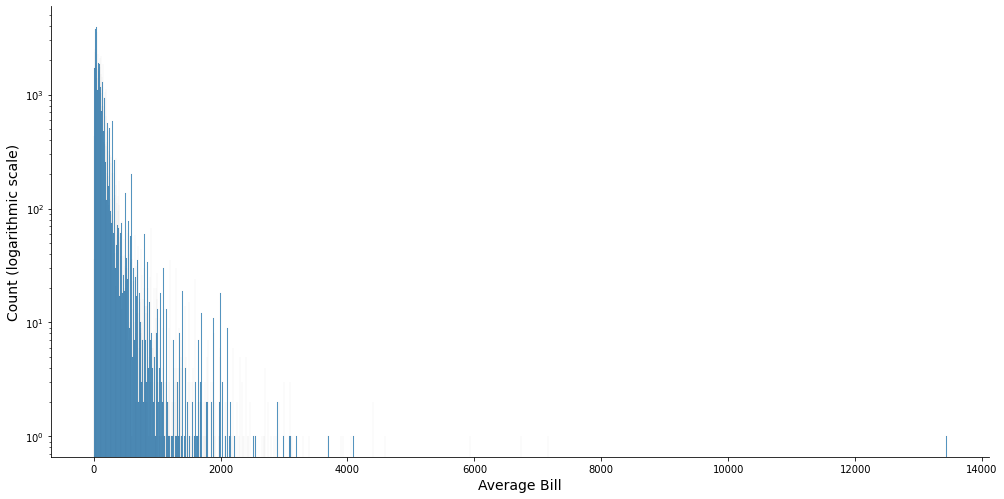

In [90]:
# распределение средних чеков покупателя с логарифмической шкалой Y
sns.displot(pre_rfm.avg_bill, height=7, aspect=2, log_scale=(False, True))
plt.xlabel("Average Bill", size=14)
plt.ylabel("Count (logarithmic scale)", size=14)

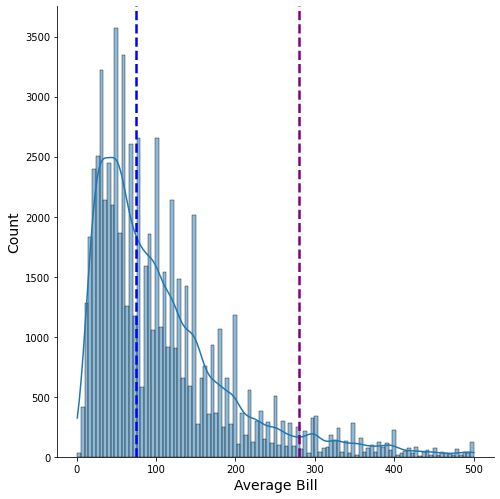

In [91]:
# распределение средних чеков покупателя, левая часть более детально 
sns.displot(pre_rfm.avg_bill[pre_rfm.avg_bill < 500], height=7, aspect=1, kde=True)
plt.xlabel("Average Bill", size=14)
plt.ylabel("Count", size=14)

plt.axvline(x=75,              # синяя пунктирная линия - граница между 1 и 2 группами
            color='blue',
            ls='--', 
            lw=2.5)
plt.axvline(x=280,             # фиолетовая пунктирная линия - граница между 2 и 3 группами
            color='purple',
            ls='--', 
            lw=2.5)

Для начала попытаемся определит интервалы, интерпретирую графики.
Глядя на рапсределение можно выделить следующие группы:
От 0 до значения чуть меньшего медианы - 75.  
Вторая - свыше 75 до 280.  
Третья - свыше 280.  
На границах этих групп заметны значительные перепады, или изменение характера апроксимирующей кривой графика.

### Далее с попощью метода К-средних определим порги и назначим номера кластеров для каждой из метрик.
Следующим шагом определим оптимальное количство кластеров для колонки со средними чеками с помощью метода локтя. Для этого напишем функцию.

In [92]:
def optimal_cluster_number(X, n_clucter_max=7):
    '''
    Функция рисует график для определения оптимального количества кластеров, который строится с момощью метода локтя 
    X - пандосовская серия
    n_clucter_max - максимальное количество кластеров
    '''
    error_rates = []
    for i in range(1, n_clucter_max + 1):
        model = KMeans(n_clusters = i, random_state = 42)  # создадим экземпляр класса KMeans
        model.fit(X.values.reshape(-1,1))                                      # преобразуем 1D массив в 2D и обучим модель 
        error_rates.append(model.inertia_)                                     # наполняем список для построения графика

    plt.plot(range(1, n_clucter_max + 1), error_rates)
    plt.xlabel("Number of Cluster", size=14)
    plt.ylabel("Errors", size=14)

Находим оптимальное количество кластеров для среднего чека.
Сначала попробуем привести колонку со средними чеками к нормальному виду, на сколько это возможно, с помощью Box-Cox трансформации, иначе имеющиеся выбросы исказят результат.

In [93]:
# трнасформируем средний чек и соединим его с нетрансформированным
transformed_data, best_lambda = boxcox(pre_rfm.avg_bill)
trans_avg_bill = pd.DataFrame(transformed_data, columns=['trans_bill'])
trans_avg_bill['avg_bill'] = pre_rfm.avg_bill

Text(-2.5749999999999957, 0.5, 'Count')

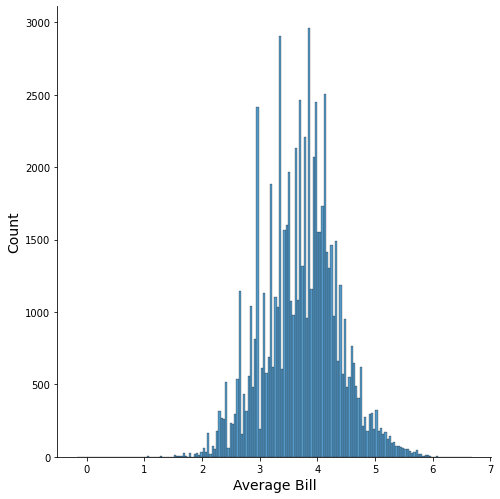

In [94]:
# распределение средних чеков покупателя после Box-Cox трансформации
sns.displot(trans_avg_bill.trans_bill, height=7, aspect=1)
plt.xlabel("Average Bill", size=14)
plt.ylabel("Count", size=14)

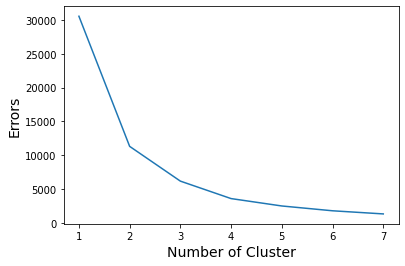

In [95]:
# ищем оптимальное количество кластеров
optimal_cluster_number(trans_avg_bill.trans_bill)

Оптимальное количество кластеров - 3.

Далее напишем функцию, определения границ.

In [96]:
def get_borders(X, n_clusters):
    '''
    Функция возвращает список границ кластеров
    Принимает на вход:
        X - пандосовская серия
        n_clusters - количество кластеров
    '''
    model = KMeans(n_clusters=n_clusters, random_state = 0)     # создадим экземпляр класса KMeans
    model.fit(X.values.reshape(-1,1))                           # преобразуем 1D массив в 2D и обучим модель 
    clusters = model.labels_                                    # кластеры   

    df = X.to_frame()                                           # переведём серию в датафрэйм
    df['clusters'] = clusters                                   # добавим колонку с кластерами

    borders = [df.iloc[:, 0].min()]                             # добавим минимальное значение в список
    
    for i in range(n_clusters):
        border = df.query('clusters == @i').iloc[:, 0].max()    # отбираем максимальные значения при определённых значениях clusters
        borders.append(border)                                  # добавляем в список
    
    return sorted(borders)                                      # возвращаем сортированный список границ

In [97]:
# границы трансформированного прайса
m_borders_trans = get_borders(trans_avg_bill.trans_bill, 3)
m_borders_trans

[-0.16357153776368474,
 3.3874745946115015,
 4.192064008392137,
 6.674620484481876]

In [98]:
# переведём границы трансформированного прайса в нетрансформированные
m_borders = []
for i in m_borders_trans:
    m_borders.append(trans_avg_bill[trans_avg_bill.trans_bill == i].avg_bill.values[0])

In [99]:
# границы интервалов Monetary
m_borders

[0.85, 51.7, 163.52, 13440.0]

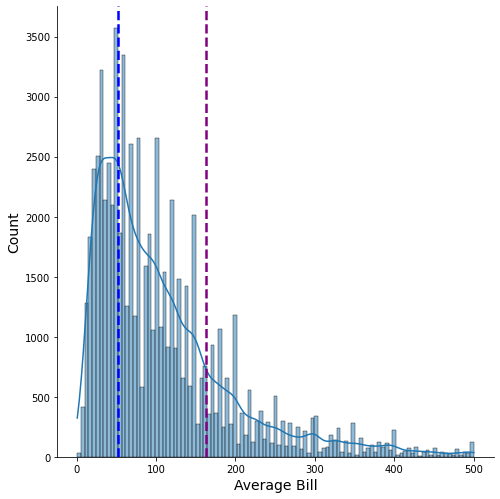

In [100]:
# распределение средних чеков покупателя, с нанесёнными границами (левая часть более детально)
sns.displot(pre_rfm.avg_bill[pre_rfm.avg_bill < 500], height=7, aspect=1, kde=True)
plt.xlabel("Average Bill", size=14)
plt.ylabel("Count", size=14)

plt.axvline(x=m_borders[1],              # синяя пунктирная линия - граница между 1 и 2 группами
            color='blue',
            ls='--', 
            lw=2.5)
plt.axvline(x=m_borders[2],             # фиолетовая пунктирная линия - граница между 2 и 3 группами
            color='purple',
            ls='--', 
            lw=2.5)

Назначим рейтинги (номера кластеров) для колонки monetary

In [101]:
# назначаем рейтинг для Monetary
m_labels = (1, 2, 3)
m_score_bins = m_borders

m_score = (
    pd.cut(pre_rfm.avg_bill, 
                   bins=m_score_bins, 
                   labels = m_labels, 
                   right=True,
                   include_lowest = True)
)

### Frequency

In [102]:
# доля пользователей, сделавших только один заказ
single_order_perc = (
    pre_rfm.purchases_quantity.value_counts()[1]
    /
    pre_rfm.purchases_quantity.count()
)
print(f'{100 * single_order_perc:.2f}% пользователей сделали только один заказ.')

97.49% пользователей сделали только один заказ.


In [103]:
pre_rfm.purchases_quantity.value_counts()

1     71240
2      1709
3        96
4        16
5         5
7         3
11        1
9         1
Name: purchases_quantity, dtype: int64

Text(3.829765625000004, 0.5, 'Count (logarithmic scale)')

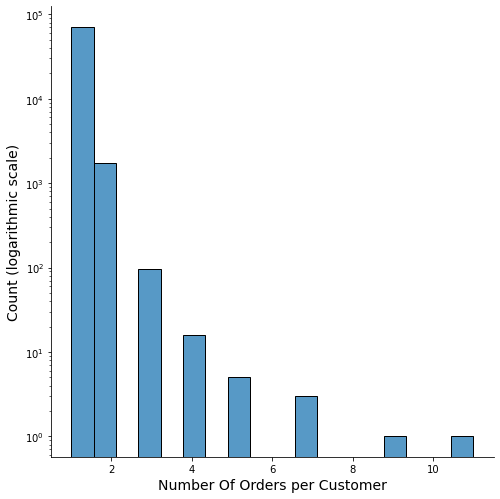

In [104]:
# распределение количества заказов покупателя с логарифмической шкалой Y
sns.displot(pre_rfm.purchases_quantity, height=7, aspect=1, log_scale=(False, True))
plt.xlabel("Number Of Orders per Customer", size=14)
plt.ylabel("Count (logarithmic scale)", size=14)

Text(-8.699999999999996, 0.5, 'Count')

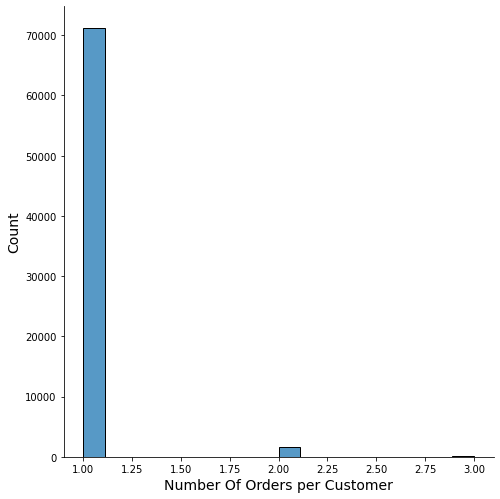

In [105]:
# распределение количества заказов на покупателя с количеством покупок <= 3
sns.displot(pre_rfm.purchases_quantity[pre_rfm.purchases_quantity <= 3], height=7)
plt.xlabel("Number Of Orders per Customer", size=14)
plt.ylabel("Count", size=14)

Text(3.8000000000000043, 0.5, 'Count')

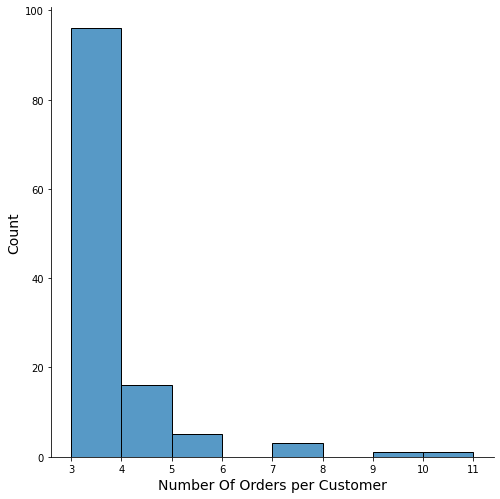

In [106]:
# распределение количества заказов на покупателя с количеством покупок >= 3
sns.displot(pre_rfm.purchases_quantity[pre_rfm.purchases_quantity >= 3], height=7)
plt.xlabel("Number Of Orders per Customer", size=14)
plt.ylabel("Count", size=14)

Аналогичным образом, попытаемся определит интервалы интерпретируюя графики.  
Глядя на цифры и распределения видим, что общую массу покупателей можно разделить на 3 группы по характерным "ступеням" - резким перепадам, показывающим своеобразный переход на новый уровень лояльности к магазину.  
Преобладают покупатели с одним количеством заказов - 71240 (97.49%). Эту часть покупателей определим в группу №1. Число покупателей, сделавших только 2 покупки - 1709 - группа №2. В третью группу возьмём оставшихся с числом покупок 3 и более.  
Итак:  
Группа 1 - только один заказ.  
Группа 2 - только два заказа.  
Группа 3 - 3 и более заказов.  

Далее воспользуемся кластеризацией методом k-средних и уточним выбранные границы.  
Находим оптимальное количество кластеров для количества покупок с помощью k-means и метода локтя. В данносм случае не требуетются какие-либо преобразования распределения.  

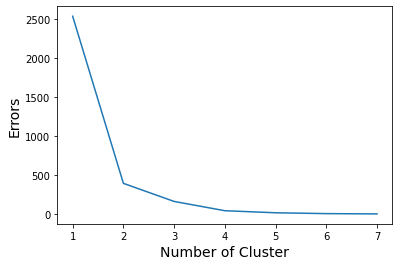

In [107]:
# оптимальное количество кластеров для purchases_quantity
optimal_cluster_number(pre_rfm.purchases_quantity)

Оптимальное количество кластеров - 3.

На основе ранее созданной функции найдём интервалы разбивки на кластеры для колонки purchases_quantity

In [108]:
# интервалы для Frequency
f_borders = get_borders(pre_rfm
                            .purchases_quantity
                        , 3)
f_borders[0] = 0                                # присвоим первому (нулевому) элементу значение 0, вместо 1, чтобы cut() мог обработать этот список
f_borders

[0, 1, 2, 11]

Здесь машинное обучение и ручной метод дали одинаковые результаты.

In [109]:
# назначаем рейтинг для Frequency
f_labels = (1, 2, 3)
f_score_bins = f_borders

f_score = (
    pd.cut(pre_rfm.purchases_quantity, 
                   bins=f_score_bins, 
                   labels = f_labels, 
                   right=True, 
                   include_lowest=True)
          )

### Recency

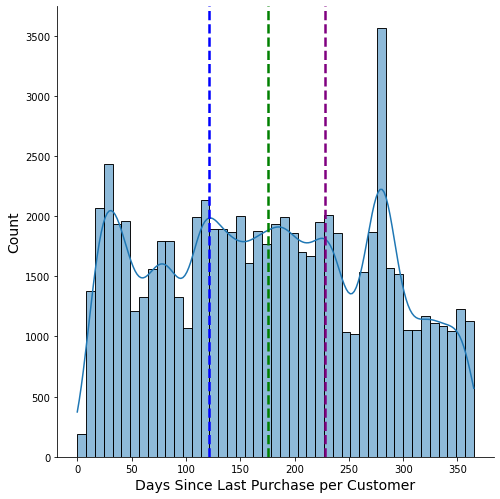

In [110]:
# распределение колонки давности последней покупки
sns.displot(pre_rfm.day_quantity, height=7, aspect=1, kde=True)
plt.xlabel("Days Since Last Purchase per Customer", size=14)
plt.ylabel("Count", size=14)

plt.axvline(x=pre_rfm.day_quantity.median(),               # зелёная пунктирная линия - медиана
            color='green',
            ls='--', 
            lw=2.5)
plt.axvline(x=pre_rfm.day_quantity.quantile(q=0.33),       # синяя пунктирная линия - 33-й процентиль
            color='blue',
            ls='--', 
            lw=2.5)
plt.axvline(x=pre_rfm.day_quantity.quantile(q=0.66),       # фиолетовая пунктирная линия - 66-й процентиль
            color='purple',
            ls='--', 
            lw=2.5)

In [111]:
# 33-й и 66-й процентили количества дней от последней покупки
pre_rfm.day_quantity.quantile(q=[0.33, 0.66])

0.33    121.0
0.66    228.0
Name: day_quantity, dtype: float64

Анализ графиков показывает, что при таком распределении имеет смысл взять рвные части по количеству пользователей соответствующих 33-му и 66-му процентилю.  
Группа 3 - от 0 до 120 дней     (недавние)  
Группа 2 - от 121 до 227 дней   (относительно недавние)  
Группа 1 - от 228 дней и более  (давние)  

Также воспользуемся кластеризацией методом k-средних для уточнения границ кластеров.

Находим оптимальное количество кластеров для количества дней с помощью k-means и метода локтя.

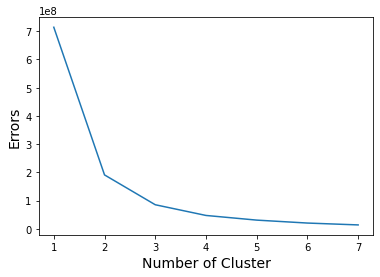

In [112]:
# оптимальное количество кластеров для day_quantity
optimal_cluster_number(pre_rfm.day_quantity)

Также, берём 3.

На основе ранее созданной функции найдём интервалы разбивки на кластеры для колонки day_quantity

In [113]:
# границы разбивки для recency
r_borders = get_borders(pre_rfm.day_quantity, 3)
r_borders

[0, 121, 238, 365]

Наблюдаются небольшие расхождения между машинной кластеризацией и кластеризацией на основе анализа графика распределения.

In [114]:
# назначаем рейтинг для recency
r_labels = (3, 2, 1)
r_score_bins = r_borders

r_score = (pd.cut(pre_rfm.day_quantity, 
                   bins=r_score_bins, 
                   labels = r_labels, 
                   right=True, 
                   include_lowest=True)
          )

In [115]:
# создадим общий датафрэйм, добавив в него рейтинги R, F, M
rfm_kmeans = (
    pre_rfm
        .copy()
        .drop('last_order', axis=1)
        .assign(recency   = r_score,
                frequency = f_score,
                monetary  = m_score)
)

In [116]:
rfm_kmeans.head()

,customer,avg_bill,purchases_quantity,day_quantity,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,116,3,1,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,119,3,1,1
2,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,326,1,1,1
3,0004aac84e0df4da2b147fca70cf8255,180.00,1,293,1,1,3
4,0004bd2a26a76fe21f786e4fbd80607f,154.00,1,151,2,1,2


Визуализируем количество пользователей по кластерам по каждой метрике.

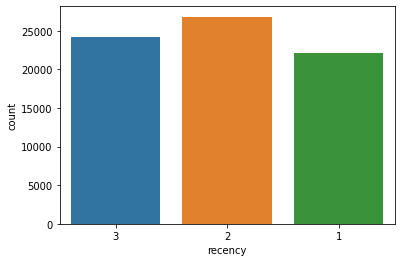

In [117]:
sns.countplot(data=rfm_kmeans, x='recency')

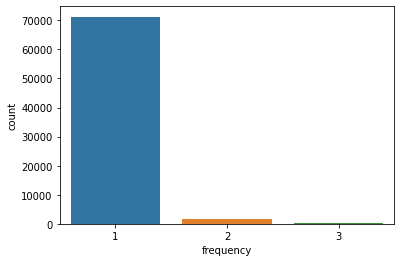

In [118]:
sns.countplot(data=rfm_kmeans, x='frequency')

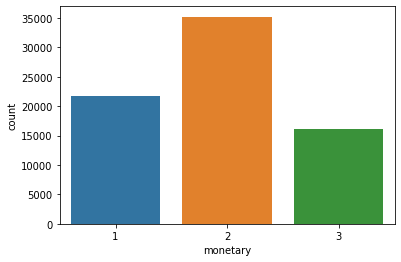

In [119]:
sns.countplot(data=rfm_kmeans, x='monetary')

In [120]:
# среднее recency по кластерам для k-means
avg_recency_kmeans = (
    rfm_kmeans
        .pivot_table(index='recency', values='day_quantity')
        .reset_index()
        .rename(columns={'recency': 'cluster',
                        'day_quantity': 'recency'})
)

In [121]:
# среднее frequency по кластерам для k-means
avg_frequency_kmeans = (
    rfm_kmeans
        .pivot_table(index='frequency', values='purchases_quantity')
        .reset_index()
        .rename(columns={'frequency': 'cluster',
                        'purchases_quantity': 'frequency'})
)

In [122]:
# среднее monetary по кластерам для k-means
avg_monetary_kmeans = (
    rfm_kmeans
        .pivot_table(index='monetary', values='avg_bill')
        .reset_index()
        .rename(columns={'monetary': 'cluster',
                        'avg_bill': 'monetary'})
)

In [123]:
# сводная таблица средних значений recency, frequency и monetary по кластерам
avg_rfm_kmeans = (
    avg_recency_kmeans
        .merge(avg_frequency_kmeans, on='cluster')
        .merge(avg_monetary_kmeans, on='cluster')
        .sort_values('cluster')
        .reset_index(drop=True)
)

Покажем средние значения метрик по кластерам одной таблицей

In [124]:
avg_rfm_kmeans

,cluster,recency,frequency,monetary
0,1,296.764674,1.00000,32.319592
1,2,180.105285,2.00000,98.528464
2,3,63.397975,3.42623,366.233292


###  Чтобы понять объективность и адекватность выбранного пути, воспользуемся готовым решением, разработанным Александром Приходько (скрипт RFMizer) для RFM-анализа в качестве своеобразной проверки и сравним результаты.

Подготовим CSV-файл для rfm-анализа с помощью скрипта [RFMizer](https://github.com/Slony/rfmizer). Этот файл не лимитируем по времени, т.к. в конфигурационном файле есть возможность указать необходимый период. Плюс, данный скрипт дополнительно использует ещё один период "за границами" первого, чтобы выделить тех, кто покупал раньше, но перестал сейчас.

In [125]:
# датафрэйм для RFM-анализа с помощью скрипта RFMizer
rfmizer_df = (
    purchase_total_df
        .groupby('order_id')
        .agg({'order_purchase_timestamp': 'max', 'customer_unique_id': 'first', 'price': 'sum'})  
        .rename(columns={'order_purchase_timestamp': 'order_date',                                # переименуем колонки как просит скрипт
                        'customer_unique_id': 'user_id',
                        'price': 'order_value'})
)
rfmizer_df['order_date'] = rfmizer_df['order_date'].dt.date                                       # переведём в формат дат, чтобы корректро записалось в CSV и считалось скриптом

rfmizer_df.head()

,order_date,user_id,order_value
order_id,,,
00010242fe8c5a6d1ba2dd792cb16214,2017-09-13,871766c5855e863f6eccc05f988b23cb,58.90
00018f77f2f0320c557190d7a144bdd3,2017-04-26,eb28e67c4c0b83846050ddfb8a35d051,239.90
000229ec398224ef6ca0657da4fc703e,2018-01-14,3818d81c6709e39d06b2738a8d3a2474,199.00
00024acbcdf0a6daa1e931b038114c75,2018-08-08,af861d436cfc08b2c2ddefd0ba074622,12.99
00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04,64b576fb70d441e8f1b2d7d446e483c5,199.90


In [126]:
# сохраним в CSV-файл для передачи скрипту
rfmizer_df.to_csv('rfmizer_df.csv', encoding='utf8', sep=',', index = False)

__*config.yaml*__ файл скрипта имеет следующую конфигурацию:
```
input_columns:  
  - order_date
  - user_id
  - order_value
segments_count:  
  recency: 3  
  frequency: 3  
  monetary: 3  
rfmizer:  
  look_back_period: 365 # earliest date for RFMizer (number of days)  
  output_columns:  
    user_id: user_id  
    recency: recency  
    frequency: frequency  
    monetary: monetary  
predictor:  
  prediction_period: 182 # lookback window for RFMestimator (number of days)
output_path: .
output_file_prefix: rfm-3-3-3-365-182
```

После обработки __*rfmizer_df.to_csv*__ скриптом откроем результирующие файлы.  

In [127]:
# скачиваем файлы данных в папку скрипта

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = ['https://disk.yandex.ru/d/bzmXyGmXAKYuZw', 
              'https://disk.yandex.ru/d/CRy5LIA9eu7drQ']                # ссылки на данные

file_names = ['rfm-3-3-3-365-182_borders.csv', 
              'rfm-3-3-3-365-182_mapping.csv']                                            # имена файлов

for i in range(2):
    # получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key[i]))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    with open(file_names[i], 'wb') as f:
        f.write(download_response.content)

In [128]:
# файл с границами групп
borders = pd.read_csv('rfm-3-3-3-365-182_borders.csv')
borders

,dimension,segment,border
0,frequency,1,2.00
1,frequency,2,3.00
2,monetary,1,57.95
3,monetary,2,125.02
4,recency,1,-229.00
5,recency,2,-121.00


Частота покупок: границы полностью совпадают с расчитанными ранее.  
Средний чек: в варианте, расчитанном с помощью k-means, границы были 51.7 и 163.52, в решении скрипта - 57.95 и 125.02, соответственно    
Давность последнего заказа: в первом варианте - 121 и 238, в проверочном - 121 и 229.  
Значения границ получились достаточно близкими.  

Прочитаем файл результата RFM-анализа.

In [129]:
mapping = pd.read_csv('rfm-3-3-3-365-182_mapping.csv')
mapping.head()

,user_id,frequency,monetary,recency
0,871766c5855e863f6eccc05f988b23cb,1,2,1
1,eb28e67c4c0b83846050ddfb8a35d051,1,1,1
2,3818d81c6709e39d06b2738a8d3a2474,1,3,1
3,af861d436cfc08b2c2ddefd0ba074622,1,1,3
4,64b576fb70d441e8f1b2d7d446e483c5,0,0,0


Нулевой кластер - это пользователи, у которых нет заказов за отчётный период, но есть более старые заказы.

Визуализируем количество пользователей по кластерам по каждой метрике.

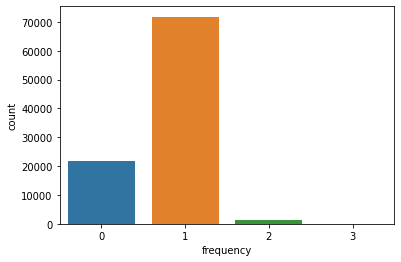

In [130]:
# визуализация frequency по кластерам
sns.countplot(data=mapping, x='frequency')

In [131]:
mapping.frequency.value_counts()

1    71791
0    21905
2     1203
3       84
Name: frequency, dtype: int64

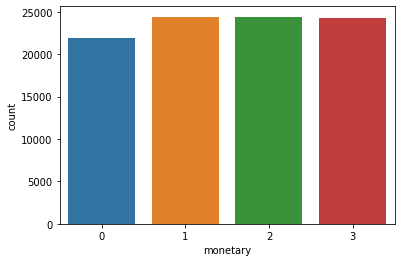

In [132]:
# визуализация monetary по кластерам
sns.countplot(data=mapping, x='monetary')

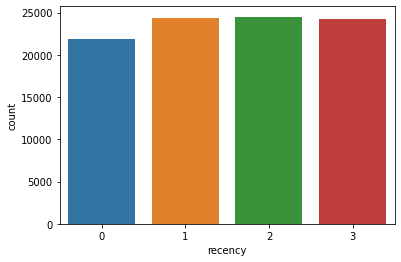

In [133]:
# визуализация recency по кластерам
sns.countplot(data=mapping, x='recency')

Объединим датафрэймы с кластерами (**mapping**) и с агрегированными данными по пользователям (**pre_rfm_all_years**).

In [134]:
# переименуем колонку с пользователями
mapping.rename(columns={'user_id': 'customer'}, inplace=True)

In [135]:
# объединяем датафрэймы
rfm_rfmizer = pre_rfm_all_years.merge(mapping, on='customer')

In [136]:
# уберём колонку со временем последней покупки
rfm_rfmizer.drop('last_order', axis=1, inplace=True)

In [137]:
# финальный датафрэйм
rfm_rfmizer.head()

,customer,avg_bill,purchases_quantity,day_quantity,frequency,monetary,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,116,1,3,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,119,1,1,3
2,0000f46a3911fa3c0805444483337064,69.00,1,542,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,326,1,1,1
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,293,1,3,1


In [138]:
# среднее значение recency по кластерам
avg_recency = (
    rfm_rfmizer
        .groupby('recency', as_index=False)
        .agg({'day_quantity': 'mean'})
        .rename(columns={'recency': 'cluster', 'day_quantity': 'recency'})
)

In [139]:
avg_recency

,cluster,recency
0,0,465.622506
1,1,290.850373
2,2,175.039781
3,3,63.397975


In [140]:
# среднее значение frequency по кластерам
avg_frequency = (
    rfm_rfmizer
        .groupby('frequency', as_index=False)
        .agg({'purchases_quantity': 'mean'})
        .rename(columns={'frequency': 'cluster', 'purchases_quantity': 'frequency'})
)

In [141]:
# среднее значение monetary по кластерам
avg_monetary= (
    rfm_rfmizer
        .groupby('monetary', as_index=False)
        .agg({'avg_bill': 'mean'})
        .rename(columns={'monetary': 'cluster', 'avg_bill': 'monetary'})
)

Покажем средние значения метрик по кластерам одной таблицей

In [142]:
# объединяем три датафрэйма в один
avg_rfm_rfmizer = avg_recency.merge(avg_frequency, on='cluster').merge(avg_monetary, on='cluster')
avg_rfm_rfmizer

,cluster,recency,frequency,monetary
0,0,465.622506,1.026980,138.271765
1,1,290.850373,1.015378,35.075557
2,2,175.039781,2.064007,88.604060
3,3,63.397975,3.869048,290.307382


Сравним средние значения метрик для вдух вариантов расчёта.

In [143]:
# объединим результаты расчётов с помощью скрипта и ручного для удобного сравнения
rfm_comparison_table = (
    avg_rfm_rfmizer
        .rename(columns={'recency' : 'R_rfmizer',
                        'frequency': 'F_rfmizer',
                        'monetary' : 'M_rfmizer'})
        .merge(avg_rfm_kmeans
                   .rename(columns={'recency'  : 'R_kmeans',
                                    'frequency': 'F_kmeans',
                                    'monetary' : 'M_kmeans'}),
                   on='cluster')

# найдём разницу между аналогичными метриками в процентах
        .assign(delta_R_perc = lambda x: x.R_rfmizer.sub(x.R_kmeans).mul(100).div(x.R_kmeans).round(2),
                delta_F_perc = lambda y: y.F_rfmizer.sub(y.F_kmeans).mul(100).div(y.F_kmeans).round(2),
                delta_M_perc = lambda z: z.M_rfmizer.sub(z.M_kmeans).mul(100).div(z.M_kmeans).round(2))
)

# установим порядок колонок
rfm_comparison_table =(
    rfm_comparison_table[['cluster', 'R_rfmizer', 'R_kmeans', 'delta_R_perc',
                       'F_rfmizer', 'F_kmeans', 'delta_F_perc',
                       'M_rfmizer', 'M_kmeans', 'delta_M_perc']]
)
rfm_comparison_table

,cluster,R_rfmizer,R_kmeans,delta_R_perc,F_rfmizer,F_kmeans,delta_F_perc,M_rfmizer,M_kmeans,delta_M_perc
0,1,290.850373,296.764674,-1.99,1.015378,1.00000,1.54,35.075557,32.319592,8.53
1,2,175.039781,180.105285,-2.81,2.064007,2.00000,3.20,88.604060,98.528464,-10.07
2,3,63.397975,63.397975,0.00,3.869048,3.42623,12.92,290.307382,366.233292,-20.73


Значительные отличия получились только при расчёте Monetary, что связано с большими отличиями в границах кластеров данной метрики при k-means кластеризации и расчёте с помощью скрипта. В целом можно сказать, что разработанный метод кластеризации методом k-средних даём приемлемые результаты.

### Средние значения метрик R, F, M для каждого кластера

In [144]:
avg_rfm_kmeans

,cluster,recency,frequency,monetary
0,1,296.764674,1.00000,32.319592
1,2,180.105285,2.00000,98.528464
2,3,63.397975,3.42623,366.233292


In [145]:
# добавляем колонку RFM
rfm_kmeans['RFM'] = rfm_kmeans.apply(lambda x: str(x.recency) + str(x.frequency) + str(x.monetary), axis=1)

In [146]:
rfm_kmeans.head()

,customer,avg_bill,purchases_quantity,day_quantity,recency,frequency,monetary,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,116,3,1,2,312
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,119,3,1,1,311
2,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,326,1,1,1,111
3,0004aac84e0df4da2b147fca70cf8255,180.00,1,293,1,1,3,113
4,0004bd2a26a76fe21f786e4fbd80607f,154.00,1,151,2,1,2,212


Посмотрим на количество покупателей по результирующим сегментам

In [147]:
# количество пользователей по каждому сегменту
customer_count = (
            rfm_kmeans
                .groupby('RFM', as_index=False)
                .agg({'customer': 'count'})
                .rename(columns={'customer': 'customer_number'})
)

Следующая таблица отражает сегменты и средние значения recency, frequency и monetary для них, а также количество пользователей по каждому сегменту.

In [148]:
rfm_mean = (
    rfm_kmeans
        .groupby('RFM', as_index=False)
        .agg({'day_quantity':      'mean',
             'purchases_quantity': 'mean',
             'avg_bill':           'mean'})
        
        # переименуем колонки
        .rename(columns={'day_quantity':      'recency_mean',
                        'purchases_quantity': 'frequency_mean',
                        'avg_bill':           'monetary_mean'})

        # добавим количество пользователей по сегментам
        .merge(customer_count, on='RFM')
)

In [149]:
rfm_mean

,RFM,recency_mean,frequency_mean,monetary_mean,customer_number
0,111,296.109944,1.000000,32.532826,6285
1,112,296.991337,1.000000,97.125535,10505
2,113,297.248866,1.000000,366.098577,4850
3,121,296.442308,2.000000,37.638750,104
4,122,295.460465,2.000000,92.634163,215
5,123,294.593407,2.000000,317.907473,91
6,132,283.583333,3.250000,99.776875,12
7,133,352.000000,3.000000,396.566667,1
8,211,182.203252,1.000000,32.128819,7995
9,212,179.221622,1.000000,99.599351,12404
